# TAL - démonstration: tokenization, aperçus, vectorisation


- 1. Chargement des données
- 2. Tokenization: séparer les \"mots\" d'un texte (on parle plutot de *types*)
- 3. Étude de la distribution de fréquence d'apparition des type
- 4. Première exploration, en vue de la Classification des texte
- 5.1 Vectorisation des textes (à faire à la main aussi, en TP)
- 5.2 Vectorisation, avec un grand Vocabulaire
- 6. Comparer tous les vecteurs pour voir si les domaines se dégagent


In [1]:
## il faudrait peut-être installer quelques modules: par exemple en faisant:
# !pip install sklearn pandas seaborn wordcloud gensim

In [2]:
import numpy as np
import pandas as pd
import json  # pour importer des fichiers json
import matplotlib.pyplot as plt  ## classique pour les plots
import seaborn as sns            ## autre librairie pour faire de jolis plots
import sklearn.decomposition     ## Pour la PCA


from collections import Counter      # un package qui permet de faire un compteur d'occcurences (de types par exemple) en qq lignes.
from sklearn.feature_extraction.text import CountVectorizer 

## pour qqs systèmes il peut être utile d'ignorer les warnings 
## à cause des caractèrs unicode pas présents sur votre système :
import warnings
warnings.filterwarnings("ignore") # retour au défaut : 'default'

# 1. Chargement des données

In [3]:
# un fichier json contenant les sous titres de plein de vidéos youtube
videos = json.loads(open('french_yt_videos.json').read())

In [4]:
# videos

In [5]:
## chaque entrée de "videos" est un dictionnaire contenant plusieurs clefs:
videos[0].keys()

dict_keys(['title', 'keywords', 'category', 'text'])

In [6]:
## on peut regarder le contenu de la premiere entrée
videos[0]

{'title': "Inside Cyrielle Gulacsy's Parisian apartment | Une Fille, Un Style | Vogue Paris",
 'keywords': ['Vogue',
  'Paris',
  'Mode',
  'Video',
  'Style',
  'Beauté',
  'Beauty',
  'Fashion',
  'Week',
  'Model',
  'Top',
  'Mannequin',
  'Une Fille Un Style',
  'Cyrielle Gulacsy',
  'Pointillism',
  'Timberland',
  'James Turrell',
  'Joan Miro',
  'Sol LeWitt',
  'Stephen Hawking',
  'Art',
  'Artiste',
  'Artist',
  'Peinture',
  'Painting'],
 'category': 'Howto & Style',
 'text': "Je m'appelle Cyrielle Gulacsy, je suis artiste, je travaille principalement à la peinture, mais\xa0depuis peu\xa0aussi en volume et avec des pièces qui sont plus en mouvement. Mes parents sont tous les deux architectes, donc ils m'ont mis un peu les crayons dans les mains depuis toute petite. J'ai tout de suite aimé ça et j'ai fait grandir cette passion avec le temps. Je dirais que mon travail parle du réel, un réel qui n'est pas forcément appréhendable par l'œil humain, ni perceptible. En ce moment,

In [7]:
## pour chaque entrée (vidéo), on extrait le texte (notre X) et la catégorie (le y)
texts = [entree['text'].lower() for entree in videos ]   
ys    = [entree['category']     for entree in videos ]  

In [8]:
len(texts), set(ys), len(set(ys))

(292,
 {'Autos & Vehicles',
  'Comedy',
  'Entertainment',
  'Film & Animation',
  'Gaming',
  'Howto & Style',
  'Music',
  'News & Politics',
  'Nonprofits & Activism',
  'People & Blogs',
  'Pets & Animals',
  'Science & Technology',
  'Sports',
  'Travel & Events'},
 14)

## Conclusion:
on peut constater qu'il y a pas mal de catégories (14), mais heureusement il y a plus de textes (292)

### Remarque:
À ce stade, on peut faire preuve d'esprit critique et remarquer par exemple que certaines catégories pourraient être vues comme des sous-catégories de certaines autres (par exemple *Film & Animation* fait partie de *Entertainment*.

In [9]:
# from collections import Counter      # un package qui permet de faire un compteur d'occcurences (de types par exemple) en qq lignes.
Counter(ys)

Counter({'Howto & Style': 29,
         'Science & Technology': 24,
         'News & Politics': 40,
         'People & Blogs': 30,
         'Comedy': 66,
         'Film & Animation': 19,
         'Music': 13,
         'Entertainment': 46,
         'Nonprofits & Activism': 7,
         'Gaming': 5,
         'Travel & Events': 3,
         'Sports': 8,
         'Pets & Animals': 1,
         'Autos & Vehicles': 1})

In [10]:
'total:',len(texts)

('total:', 292)

Les 3 catégories avec le plus d'exemples dedans sont 'Comedy': 66, 'Entertainment': 46, 'News & Politics': 40

# 2. Tokenization: séparer les "mots" d'un texte (on parle plutot de *types*)
Comment séparer les types d'un texte ?

On utilise une expression régulière qui garde les caractères alpha numériques (`\w`) c.a.d. les lettres et chiffres mais pas les caractères spéciaux. Les espaces sont omis et les séquences de 1 ou plus caractère alphanumériques (séparés par un ou des espaces) sont donc séparés.

In [11]:
## on utilise une expression régulière:
import re
retoken = re.compile(r"\w+")
## see https://regex101.com/ to try out regular expressions !

In [12]:
texts[0][:200]

"je m'appelle cyrielle gulacsy, je suis artiste, je travaille principalement à la peinture, mais\xa0depuis peu\xa0aussi en volume et avec des pièces qui sont plus en mouvement. mes parents sont tous les deux"

In [13]:
# retoken.findall(texts[0])

In [14]:
# list(retoken.findall(texts[0]))

In [15]:
## petit exemple:
print(list(retoken.findall(texts[0]))[:35])

['je', 'm', 'appelle', 'cyrielle', 'gulacsy', 'je', 'suis', 'artiste', 'je', 'travaille', 'principalement', 'à', 'la', 'peinture', 'mais', 'depuis', 'peu', 'aussi', 'en', 'volume', 'et', 'avec', 'des', 'pièces', 'qui', 'sont', 'plus', 'en', 'mouvement', 'mes', 'parents', 'sont', 'tous', 'les', 'deux']


# 3. Étude de la distribution de fréquence d'apparition des types



- On compte les occurences des types avec un `Counter`. En gros ça fabrique un dictionnaire:
    - dont les clefs sont les types
    - et les valeurs sont la fréquence d'occurence de ce type (le nombre de tokens trouvés pour ce type)
- Puis on regarde la fréquence d'appartion des types les plus courants

In [16]:
for i in range(len(texts)):
    text = texts[i]

In [17]:
tokcounter = Counter()
nombredetokensDstoutleTexte=0
for i, text in enumerate(texts):
    nombredetokensDstoutleTexte += len( list(retoken.findall(texts[i])) )
    tokcounter += Counter(retoken.findall(text))
print('Nous avons',len(tokcounter),'types et',\
      sum(tokcounter.values()),'tokens au total.', nombredetokensDstoutleTexte)


Nous avons 24375 types et 413284 tokens au total. 413284


In [18]:
print('Voici les 10 tokens les plus courants :', tokcounter.most_common(10))

Voici les 10 tokens les plus courants : [('de', 13323), ('est', 9795), ('et', 8242), ('la', 7663), ('le', 7216), ('que', 6696), ('c', 6651), ('à', 6432), ('un', 6205), ('je', 6200)]


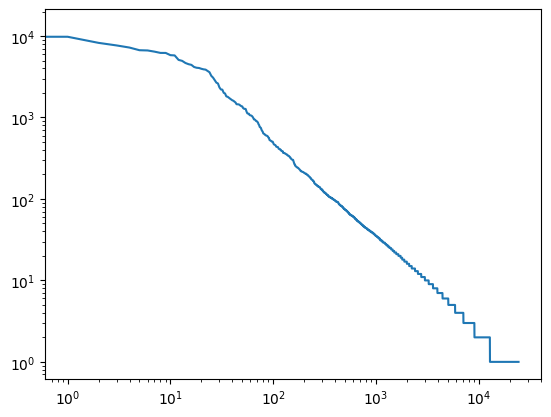

In [19]:
frequences = np.array(list(tokcounter.values()))
frequences =np.sort(frequences)[::-1]
plt.loglog(frequences)

## Conclusion: C'est la loi de Zipf ! (aussi appellée loi de puissance, ou de Pareto)

Avec Pandas on peut faire de jolis affichages facilement

<Axes: title={'center': 'Fréquence de tous les types, triés par fréquence'}>

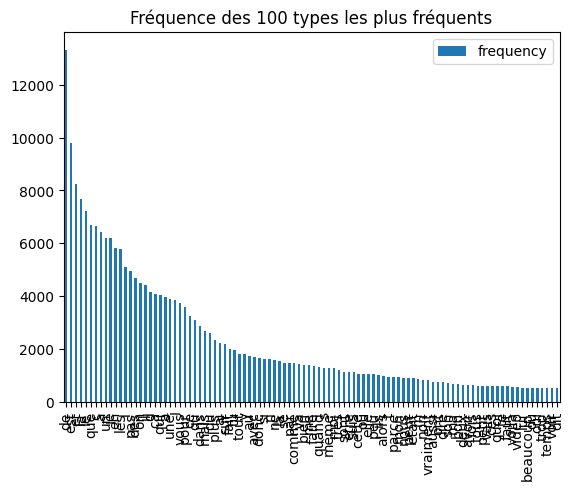

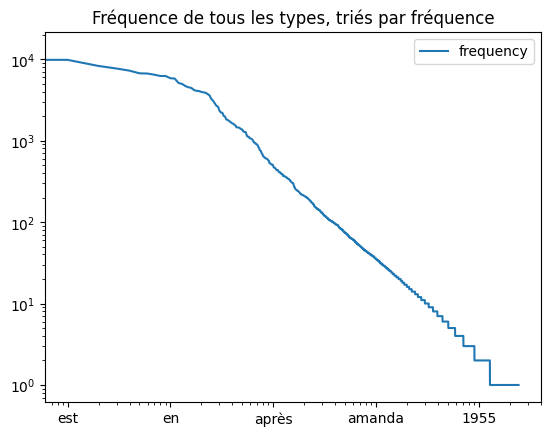

In [20]:
freq_df = pd.DataFrame.from_dict(tokcounter, orient='index', columns=['frequency']).sort_values(by='frequency', ascending=False)
freq_df.head(100).plot(kind='bar', title='Fréquence des 100 types les plus fréquents')
freq_df.plot(loglog=True, title='Fréquence de tous les types, triés par fréquence')


Si vous souhaitez creuser: en Linguistique quantitative / statistique textuelle, on remarque qu'il y a des propriétés globales quasi indépendantes du langage:
- Loi de Zipf
- Heavy-Shift
- Loi de Menzerath
- Réseau en petit monde


# 4. Première exploration, en vue de la Classification des textes

### On s'intéresse maintenant seulement aux 3 thèmes les plus présents, c.a.d. aux classes 'Science & Technology', 'News & Politics', 'Comedy'

On explore un peu, pour voir si à première vue les différentes classes sont très différentes

In [21]:
themes_d_interet = ['Science & Technology', 'News & Politics', 'Comedy']

In [22]:
texts = []
ys = []
for i, entree in enumerate(videos):
    if videos[i]['category'] in themes_d_interet:
        texts.append(entree['text'].lower())
        ys   .append(entree['category'])
len(texts)

130

In [23]:
# ys


#### Il reste 130 textes. Pas énorme mais pour une petite démo, ça passe.


In [24]:
## on passe les labels sous forme numérique, c'est parfois pratique:
encoder = sklearn.preprocessing.LabelEncoder()
y_numerique = encoder.fit_transform(ys)
y_numerique

array([2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 2, 1,
       0, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1,
       1, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 2,
       0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 0, 2, 1, 2,
       1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0],
      dtype=int64)


### Quel sont les types les plus fréquents dans chaque domaine ? Pourra-t-on classifier en regardant les types les plus fréquents ?

In [25]:
domaine2counter={} # pour réutiliser les compteurs après
for domaine in themes_d_interet:
    c = Counter()
    for texte,y in zip(texts, ys):
        if y == domaine:
            c+=Counter(retoken.findall(texte))
    print(domaine,c.most_common(10))
    domaine2counter[domaine]=c

Science & Technology [('de', 1595), ('est', 1062), ('la', 988), ('et', 981), ('le', 933), ('à', 789), ('que', 755), ('un', 730), ('l', 696), ('les', 695)]
News & Politics [('de', 2377), ('la', 1488), ('est', 1276), ('et', 1165), ('le', 1159), ('l', 1149), ('les', 1002), ('à', 996), ('en', 905), ('des', 860)]
Comedy [('est', 2263), ('de', 2116), ('c', 1783), ('je', 1710), ('un', 1401), ('le', 1362), ('que', 1327), ('et', 1312), ('pas', 1275), ('la', 1234)]


In [26]:
domaine2df={} # pour les réutiliser après
for domaine in themes_d_interet:
    print(domaine)
    freq_df = pd.DataFrame.from_dict(domaine2counter[domaine], orient='index', columns=['freq'])
    freq_df.sort_values('freq',  inplace=True, ascending=False)
    display(freq_df.head(10))
    domaine2df[domaine]=freq_df

Science & Technology


,freq
de,1595
est,1062
la,988
et,981
le,933
à,789
que,755
un,730
l,696
les,695


News & Politics


,freq
de,2377
la,1488
est,1276
et,1165
le,1159
l,1149
les,1002
à,996
en,905
des,860


Comedy


,freq
est,2263
de,2116
c,1783
je,1710
un,1401
le,1362
que,1327
et,1312
pas,1275
la,1234


### Conclusion: les 10 types les plus fréquents n'ont pas l'air très différents entre les 3 domaines.
C'est mal barré pour classifier juste avec ceux là. Ces types ne sont pas spécifiques des domaines.


# 5.1 Vectorisation des textes (à faire à la main aussi, en TP)

- On commence en définissant à la main (!) un vocabulaire V restreint, de $|V|=15$ types seulement.
- On aura donc combien de colonnes, après passage en one-hot ? 

$$D = ?$$

In [27]:
Vocabulaire = "science technologie statistique ordinateur calcul \
                nouvelles politique gouvernement élections parlement \
                comédie drôle blague rire humour".split()
Vocabulaire
## si vous pensez à d'autres types, allez-y !

['science',
 'technologie',
 'statistique',
 'ordinateur',
 'calcul',
 'nouvelles',
 'politique',
 'gouvernement',
 'élections',
 'parlement',
 'comédie',
 'drôle',
 'blague',
 'rire',
 'humour']

#### Remarque: 
`CountVectorizer` fait la tokenization et le passage en one-hot d'un coup:

Allez lire https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
pour comprendre les options !

In [28]:
# regexp = r"(?u)\b\w\w+\b" ## sklearn default (supprimera les tokens de 1 seul caractère... pas top en francais ?)
regexp = r"\b\w+\b" # on peut controler la tokenization implicite en définissant, en particulier, l'expression régulière
vectorizer = CountVectorizer(vocabulary=Vocabulaire, binary=True, token_pattern=regexp)
X_one_hot = vectorizer.fit_transform(texts)

In [29]:
## Ça fabrique un output sparse (matrice creuse). 
## Très bien pour la mémoire, mais pas top pour l'affichage:
X_one_hot.shape, X_one_hot

((130, 15),
 <130x15 sparse matrix of type '<class 'numpy.int64'>'
 	with 141 stored elements in Compressed Sparse Row format>)

In [30]:
## comme nos données (et vocabulaire) sont très petits, on passe en représentation dense
## (matrice pleine)
X_one_hot_dense = X_one_hot.toarray()
X_one_hot_dense

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [31]:
X_one_hot_dense[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int64)

## On fait une PCA, pour voir si les points (en dimension D) sont séparés ou non:

In [32]:
maPCA = sklearn.decomposition.PCA(n_components=2)
maPCA.fit(X_one_hot_dense)
X_transformee = maPCA.transform(X_one_hot_dense)

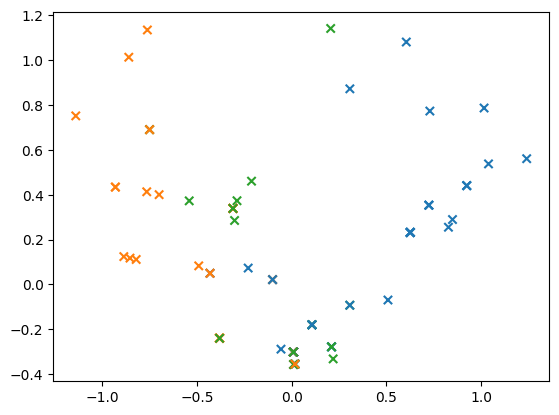

In [33]:
import matplotlib.cm as cm
mycolorBar = cm.tab10
plt.scatter(X_transformee[:,0], X_transformee[:,1], c=mycolorBar(y_numerique), marker= 'x')

### Conclusion: à première vue, pas mal... mais en fait, plein de points sont les uns sur les autres !! Donc pas bon du tout pour les séparer !

On vérifie que les points sont superposés en faisant un truc un peu sale: on rajoute un bruit gaussien à chaque point

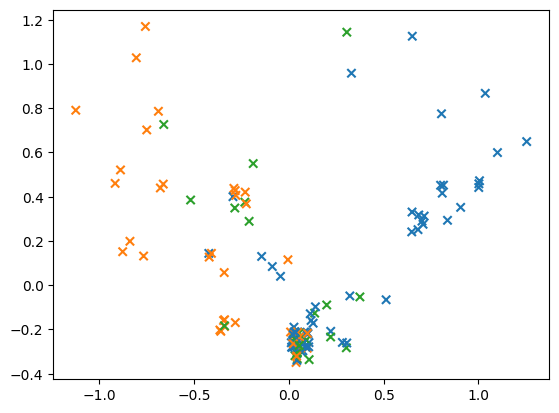

In [34]:
Ndata = X_transformee[:,0].shape[0]
bruit0 = np.random.random(Ndata)*0.1
bruit1 = np.random.random(Ndata)*0.1
# bruit0 = np.random.normal(0,1,Ndata)*0.05
# bruit1 = np.random.normal(0,1,Ndata)*0.05
plt.scatter(X_transformee[:,0]+bruit0, X_transformee[:,1]+bruit1, c=mycolorBar(y_numerique), marker= 'x')

## Pourquoi les points sont les uns sur les autres ?

On peut s'en faire une idée, avec un joli affichage avec `pandas`:

In [35]:
df_onehot_des_textes_dans_vocab_choisi = pd.DataFrame(X_one_hot_dense, columns=Vocabulaire)
df_onehot_des_textes_dans_vocab_choisi['catégories']=ys
df_onehot_des_textes_dans_vocab_choisi

,science,technologie,statistique,ordinateur,calcul,nouvelles,politique,gouvernement,élections,parlement,comédie,drôle,blague,rire,humour,catégories
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Science & Technology
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,News & Politics
2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,Comedy
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,News & Politics
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,News & Politics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy
126,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,Comedy
127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Science & Technology
128,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,News & Politics


- regardons les vecteurs de la vidéo 125, ou encore 127. Pourquoi ces vecteurs ne sont pas très prometteurs ?
- réponse :

In [36]:
df_onehot_des_textes_dans_vocab_choisi[df_onehot_des_textes_dans_vocab_choisi.index==125]

,science,technologie,statistique,ordinateur,calcul,nouvelles,politique,gouvernement,élections,parlement,comédie,drôle,blague,rire,humour,catégories
125,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Comedy


In [37]:
df_onehot_des_textes_dans_vocab_choisi[df_onehot_des_textes_dans_vocab_choisi.index==127]

,science,technologie,statistique,ordinateur,calcul,nouvelles,politique,gouvernement,élections,parlement,comédie,drôle,blague,rire,humour,catégories
127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Science & Technology


## [Optionnel] En comptant les fréquences d'occurence

- il suffit de changer un argument dans l'appel de `CountVectorizer`

In [38]:
binary = False

In [39]:
X_one_hot_dense.max()

1

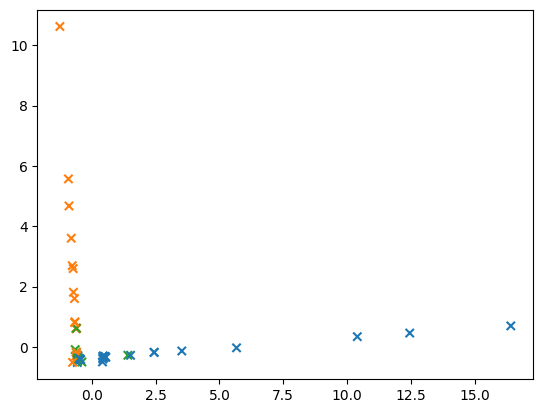

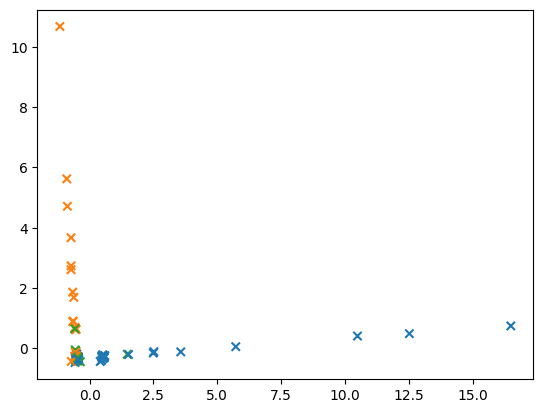

In [40]:
# regexp = r"(?u)\b\w\w+\b" ## sklearn default (supprimera les tokens de 1 seul caractère... pas top en francais ?)
regexp = r"\b\w+\b" # on peut controler la tokenization implicite en définissant, en particulier, l'expression régulière
vectorizer = CountVectorizer(vocabulary=Vocabulaire, binary=binary, \
                             token_pattern=regexp)
X_one_hot = vectorizer.fit_transform(texts)
## Ça fabrique un output sparse (matrice creuse). 
## Très bien pour la mémoire, mais pas top pour l'affichage:
## comme nos données (et vocabulaire) sont très petits, on passe en représentation dense
## (matrice pleine)
X_one_hot_dense = X_one_hot.toarray()
## On fait une PCA, pour voir si les points (en dimension D) sont séparés ou non:
maPCA = sklearn.decomposition.PCA(n_components=2)
maPCA.fit(X_one_hot_dense)
X_transformee = maPCA.transform(X_one_hot_dense)

mycolorBar = cm.tab10
plt.figure()
plt.scatter(X_transformee[:,0], X_transformee[:,1], c=mycolorBar(y_numerique), marker= 'x')
### Conclusion: à première vue, pas mal... mais en fait, plein de points sont les uns sur les autres !! Donc pas bon du tout pour les séparer !
## On vérifie que les points sont superposés en faisant un truc un peu sale: on rajoute un bruit gaussien à chaque point

plt.figure()
Ndata = X_transformee[:,0].shape[0]
bruit0 = np.random.random(Ndata)*0.1
bruit1 = np.random.random(Ndata)*0.1
# bruit0 = np.random.normal(0,1,Ndata)*0.05
# bruit1 = np.random.normal(0,1,Ndata)*0.05
plt.scatter(X_transformee[:,0]+bruit0, X_transformee[:,1]+bruit1, c=mycolorBar(y_numerique), marker= 'x')

## pourquoi cette forme bizzare, avec certains points (textes) très éloignés des autres ?

In [41]:
## on enquete sur les points qui ont une composante 0 très différente des autres:
# voici leurs indices:
np.where(X_transformee[:,1]>4)

(array([ 3,  8, 43], dtype=int64),)

In [42]:
# regardez le texte lui même, il n'a rien d'extraordinaire : 
texts[43][:499]

's\'il y a un candidat qui adore parler d\'économie c\'est bien françois fillon. et de son programme,  il y a deux gros chiffres qui ressortent 100 milliards et 500 milles mais à quoi correspondent t-il? qui sont-ils? quels sont leurs réseaux? c\'est la question auxquelles nous allons tenter de répondre. mais surtout on va s\'intéresser à ce choc de compétitivité que souhaite amener françois fillon "à force de vouloir tout orienté tout réguler tout contrôler c\'est tout un peuple c\'est tout un pays c\''

In [43]:
# par contre le vecteur a l'air intéressant
X_one_hot_dense[43]
## il y a un mot ultra fréquent !

array([ 0,  0,  0,  0,  0,  0, 11,  1,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

In [44]:
X_one_hot_dense[[3,8,43]]
## et c est le meme mot pour les 3 textes bizarres !!

array([[ 0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  5,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 11,  1,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)

In [45]:
## quel est ce mot ?
Vocabulaire[6]

'politique'

# 5.1 -> Conclusion:
    - c'est une forme très intéressante, mais encore plus difficile à séparer que le one-hot !
    - choisir les types à la carte est fastidieux et ne marche pas forcément bien car notre choix est arbitraire
    - prenons simplement **tous les types**

# 5.2 Vectorisation, avec un grand Vocabulaire 
- désormais, `Vocabulaire` = [tous les types présents dans le corpus !!]

In [46]:
X_one_hot.shape

(130, 15)

In [47]:
Vocabulaire = None ## Ça va etre compris comme "tous les types de l'input" par sklearn
binary = True

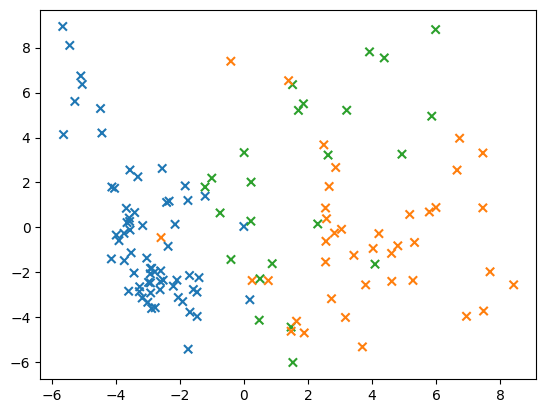

In [48]:
# regexp = r"(?u)\b\w\w+\b" ## sklearn default (supprimera les tokens de 1 seul caractère... pas top en francais ?)
regexp = r"\b\w+\b" # on peut controler la tokenization implicite en définissant, en particulier, l'expression régulière
vectorizer = CountVectorizer(vocabulary=Vocabulaire, binary=binary, token_pattern=regexp)
vectorizer = CountVectorizer(vocabulary=Vocabulaire, binary=binary)
X_one_hot = vectorizer.fit_transform(texts)
## Ça fabrique un output sparse (matrice creuse). 
## Très bien pour la mémoire, mais pas top pour l'affichage:
## comme nos données (et vocabulaire) sont très petits, on passe en représentation dense
## (matrice pleine)
X_one_hot_dense = X_one_hot.toarray()
## On fait une PCA, pour voir si les points (en dimension D) sont séparés ou non:
maPCA = sklearn.decomposition.PCA(n_components=2)
maPCA.fit(X_one_hot_dense)
X_transformee = maPCA.transform(X_one_hot_dense)

mycolorBar = cm.tab10
plt.figure()
plt.scatter(X_transformee[:,0], X_transformee[:,1], c=mycolorBar(y_numerique), marker= 'x')
### Conclusion: à première vue, pas mal... mais en fait, plein de points sont les uns sur les autres !! Donc pas bon du tout pour les séparer !
## On vérifie que les points sont superposés en faisant un truc un peu sale: on rajoute un bruit gaussien à chaque point

## Conclusion : ça a déjà l'air plus prometteur pour faire une classification automatique !


# 6. Comparer tous les vecteurs pour voir si les domaines se dégagent 

- avant de tester une classif., on peut visualiser la similitude entre vecteurs du même domaine
- comment compter le nombre de types en commun entre deux textes ?
    - multiplier les one hot !
- la multiplication entre deux vecteurs est très rapide, on peut comparer tout vecteur avec tout autre vecteur pour voir si les promximités se dégagent :

In [49]:
correlation = np.dot(X_one_hot_dense, X_one_hot_dense.T)
correlation

array([[222,  64,  82, ...,  70,  84,  56],
       [ 64, 685, 109, ...,  79, 125,  80],
       [ 82, 109, 593, ..., 114, 144, 126],
       ...,
       [ 70,  79, 114, ..., 286, 115,  83],
       [ 84, 125, 144, ..., 115, 501, 107],
       [ 56,  80, 126, ...,  83, 107, 271]], dtype=int64)

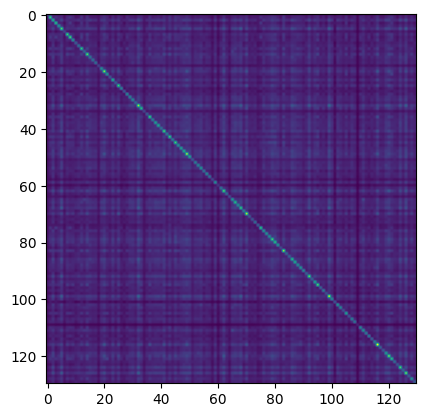

In [50]:
plt.imshow(correlation)

La diagonale est trop présente, et globalement on ne voit rien.

Trions les entrées par classe (domaine, valeur de y quoi)

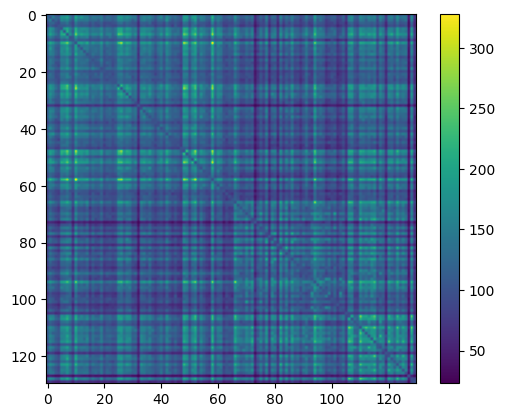

In [51]:
ordre = np.argsort(y_numerique)
correlation = np.dot(X_one_hot_dense[ordre], X_one_hot_dense[ordre].T)
correlation[np.diag_indices_from(correlation)] = 100 ## on réduit a diagonale pour mieux voir
plt.imshow(correlation)
plt.colorbar()

In [52]:
y_numerique[ordre]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

# Conclusion: si vous avez des bons yeux, vous pouvez déjà voir des groupes

### 🚧 todo:
- réponse :
    - le premier carré montre la comédi, jusqu'à 66
    - le dernier carré à partir de 105 est la science
    - scien et news se ressemblent plus

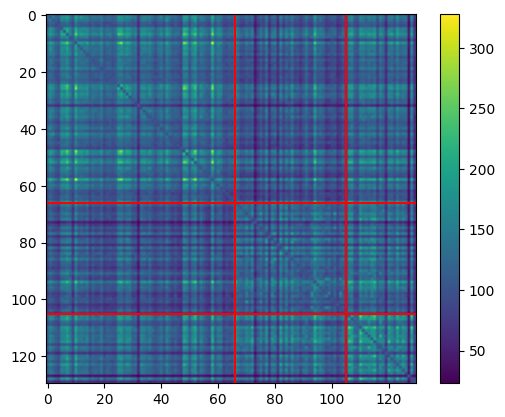

In [53]:
ordre = np.argsort(y_numerique)
correlation = np.dot(X_one_hot_dense[ordre], X_one_hot_dense[ordre].T)
correlation[np.diag_indices_from(correlation)] = 100 ## on réduit a diagonale pour mieux voir
plt.imshow(correlation)
plt.axvline(66, color='red')
plt.axvline(105, color='red')
plt.axhline(66, color='red')
plt.axhline(105, color='red')
plt.colorbar()

# la classification des textes
### 🚧 todo optionnel : 
- commencez à penser : comment faire pour classifier ?
    - décrivez les étapes à faire pour créer un classifieur de texte en domaines
    - quelle méthodes vous paraissent prometteuse ?
    - comment évaluer si ça marche ?

